# MLM Task
### This notebook is for displaying decoder self attention in T5 on MLM task (3 Examples) max_seq_length is 128
####  *Note the decoder attentions are not masked as [traditional transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) for more details look at [T5attention](https://github.com/huggingface/transformers/blob/05fa1a7ac17bb7aa07b9e0c1e138ecb31a28bbfe/src/transformers/models/t5/modeling_t5.py#L508)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
from src.T5_weights import Tester
from src.utils import load_config, create_logger
import argparse
import matplotlib.pyplot as plt

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--experiment_path', type=str, default='test_t5', help='path where to save model')
    parser.add_argument('--data_path', type=str, default=None, help='path with the sharded data in text format')
    parser.add_argument('--train_file_path', type=str, default='Data/wiki_103/128train_data.pt ',
                        help='path of processed train data')
    parser.add_argument('--valid_file_path', type=str, default='Data/wiki_103/128valid_data.pt ',
                        help='path of processed test data')

    parser.add_argument('--test_file_path', type=str, default='Data/wiki_103/128test_data.pt',
                        help='path of processed test data')
    
    
    parser.add_argument('--train_file', type=str, default=None,
                        help='The input training data file (a text file) to be processed.')
    parser.add_argument('--valid_file', type=str, default=None,
                        help='input evaluation data file to evaluate the perplexity on (a text file).')
    ##################################################
    parser.add_argument('--dataset_name', type=str, default='wikitext',
                        help='The name of the dataset to use (via the datasets library).')
    parser.add_argument('--dataset_config_name', type=str, default='wikitext-103-raw-v1',
                        help='The configuration name of the dataset to use (via the datasets library).')
    parser.add_argument('--max_seq_length', type=int, default=128,
                        help='The maximum total input sequence length after tokenization and masking. Sequences longer than this will be truncated. Default to the max input length of the model.')
    parser.add_argument('--processing_num_workers', type=int, default=1,
                        help='The number of processes to use for the preprocessing.')
    parser.add_argument('--overwrite_cache', type=bool, default=None,
                        help='Overwrite the cached training and evaluation sets')
    parser.add_argument('--mean_noise_span_length', type=float, default = 3.0, help='Mean span length of masked tokens.')
    parser.add_argument('--cache_dir', type=str, default = None, help='Where do you want to store the pretrained models downloaded from s3.')

    ##################################################
    parser.add_argument('--save_interval', type=int, default=10, help='save model every steps')
    parser.add_argument('--working_dir', type=str, default='.',
                        help='working dir, should be a dir with t5-experiments repo (default: .)')

    # model args
    parser.add_argument('--model_size', type=str, default='t5-small',
                        help='model_size specifies the base model name (from huggingface) (default: t5-small)')
    parser.add_argument('--tokenizer_path', type=str, default='tokenizer/',
                        help='tokenizer_path specifies the base tokenizer name (from huggingface) (default: t5-small)')

    parser.add_argument('--config_dir', type=str,default='./configs',
                        help='path to model configuration file (default: None)')  #  T5Mem_config.json,  t5-small
    parser.add_argument('--model_name', type=str, default='transformers:T5ForConditionalGeneration',  #Models.T5MemModel:T5MemForConditionalGeneration or transformers:T5ForConditionalGeneration
                        help='model class name to use (default: transformers:T5ForConditionalGeneration)')
    
    
    
############################ to finetune here put the checkpoint
    parser.add_argument('--init_checkpoint', type=str, default = 'MLM/128/1_model.pt',
                        help='path to init checkpoint to load a model from (default: None).')


    # training args
    parser.add_argument('--task', type=str, default="mlm", help='task type')
    parser.add_argument('--lr', type=float, default=0.005, help='learning rate (default: None)')
    parser.add_argument('--batch_size', type=int, default=3, help='input batch size for training (default: 20)')
    parser.add_argument('--max_train_steps', type=int, default=None, help='max_train_steps')
    
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training steps (i.e., gradient updates) (default: 100).')
    parser.add_argument('--patience', type=int, default=10,
                        help='number of epochs with no improvement after which learning rate will be reduced (default: 3).')
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help='number of batches to accumulate gradients for each worker; it multiplies total batch size.')
    parser.add_argument('--reduction_factor', type=float, default=0.1, help='learning rate (default: 0.1)')
    parser.add_argument('--min_lr', type=float, default=0.00000001, help='learning rate (default: 0.1)')
    parser.add_argument('--fp16-allreduce', action='store_true', default=False,
                        help='use fp16 compression during allreduce')
    parser.add_argument('--fp16', action='store_true', default=False, help='use torch.amp for fp16 training')
    parser.add_argument('--apex_opt_lvl', type=str, default='O1', help='apex opt level, O1, O2. (default: O1)')
    parser.add_argument('--optimizer', type=str, default='Adafactor',
                        help='optimizer name: AdamW, Adafactor. (default: AdamW)')
    parser.add_argument('--weight_decay', type=float, default=0.001,
                        help='optimizer weight decay (default: 0.0)')
    parser.add_argument('--scale_parameter', action='store_true', default=False,
                        help='Adafactor scale_parameter (default: False)')
    parser.add_argument('--relative_step', action='store_true', default=False,
                        help='Adafactor relative_step (default: False)')
    parser.add_argument('--warmup_init', action='store_true', default=True,
                        help='Adafactor warmup_init (default: False)')
    parser.add_argument('--warmup_steps', action='store_true', default=2000,
                        help='number of warm up steps')
    parser.add_argument('--mlm_probability', type=float, default=0.15, help= "Ratio of tokens to mask for span masked language modeling loss")
    

    parser.add_argument('--evaluate_dev', action='store_true', default=True,
                        help='Evaluating during training process(default: True)')
    
    args, unknown = parser.parse_known_args() 
    args = parser.parse_args(args=[])
    return args

def main()-> tuple:

    # load args
    args = parse_args()
    args.config_path = args.config_dir + '/t5-small.json'
    # load config
    config = load_config(args)
    tester = Tester(config, args)
    return tester.return_weights()

In [5]:
# %tb
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

encoder_attentions, cross_attentions, decoder_attentions , keys, ground_selector_tokens, decoder_input_tokens, queries, decoded_model_output= main()

file tokenizer/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


the model is:...................................................................
T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Li

  0%|                                                                                                                                                                                                                                                      | 0/889 [00:02<?, ?it/s]

1: decoded_mlm_answer using self.model.generate(source_ids) -->> 
['      ', '', '      ']
********************************************************
2: decoded_mlm_answer using self.model.generate(input_ids=source_ids,  eos_token_id=self.tokenizer.eos_token_id, do_sample=True, early_stopping=True, top_p=0.9, top_k=30,length_penalty=1.5,temperature=0.9, repetition_penalty=2.0) -->> 
['s @= of the1"', "to @-d,089s'", ', 20 was of the. in']
********************************************************
3: decoded_mlm_answer using self.model.generate(input_ids=source_ids, eos_token_id=self.tokenizer.eos_token_id, do_sample=True, early_stopping=True, top_k=40, length_penalty=2.0, emperature=0.5, repetition_penalty=2.0)-->> 
['in ', 'to , the.@ of', 'd thea wass.,']
********************************************************
*************************************************************************
answer_dict resulted from model using generate method on valid set
0 :  in 
1 :  to , the.@ of
2 :  d the

*****************************************************************************************************************************************************
********************************************************  Decoder self attention         *****************************************************************
*****************************************************************************************************************************************************
Decoder_attentions shape torch.Size([3, 8, 29, 29])
**********************************************************************************************************************************************
Decoder Layer 1
layer.shape;  torch.Size([3, 8, 29, 29])
============================================================  batch 1 ===============================================================
decoder_attention[1] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


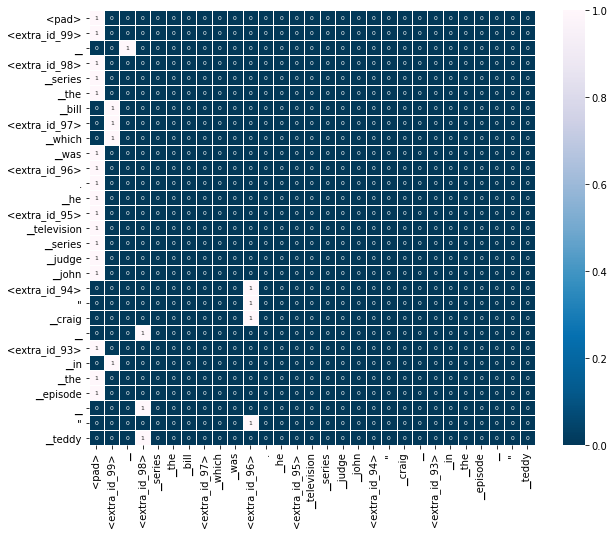

head:  2 torch.Size([29, 29])


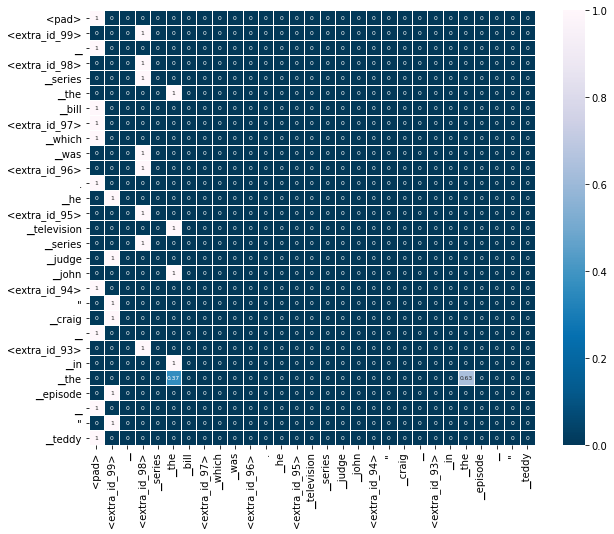

head:  3 torch.Size([29, 29])


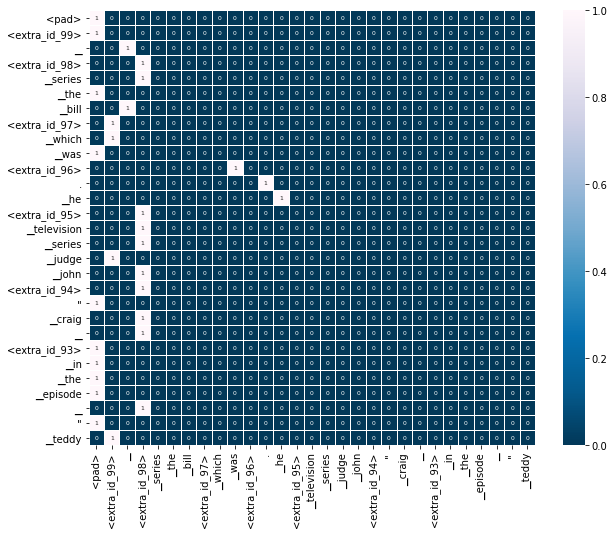

head:  4 torch.Size([29, 29])


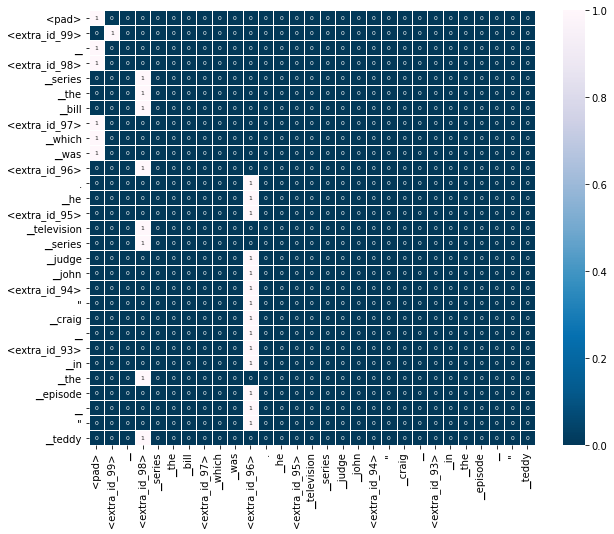

head:  5 torch.Size([29, 29])


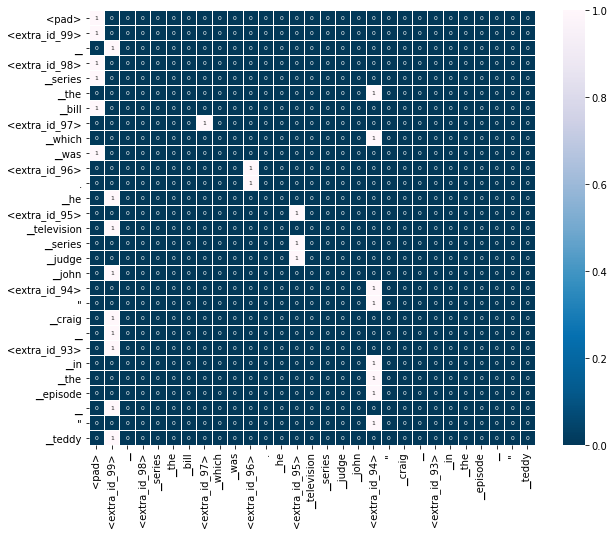

head:  6 torch.Size([29, 29])


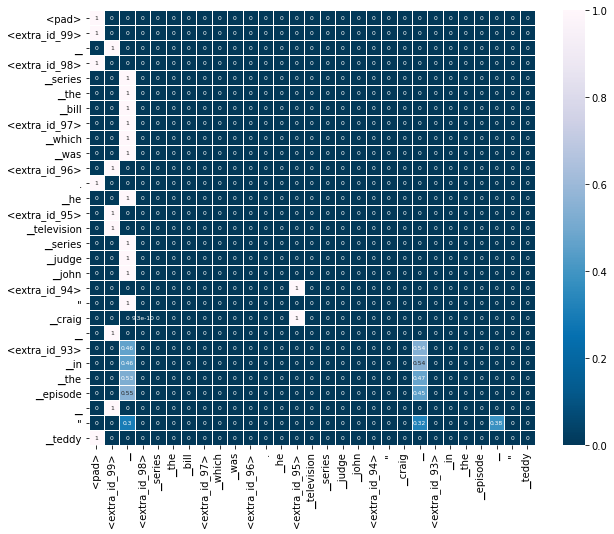

head:  7 torch.Size([29, 29])


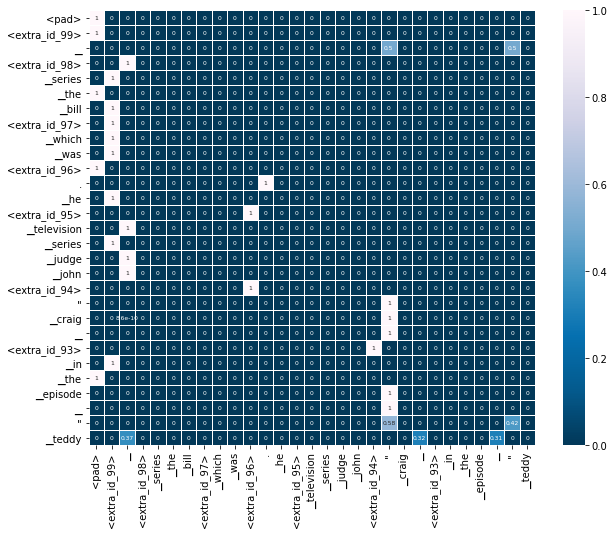

head:  8 torch.Size([29, 29])


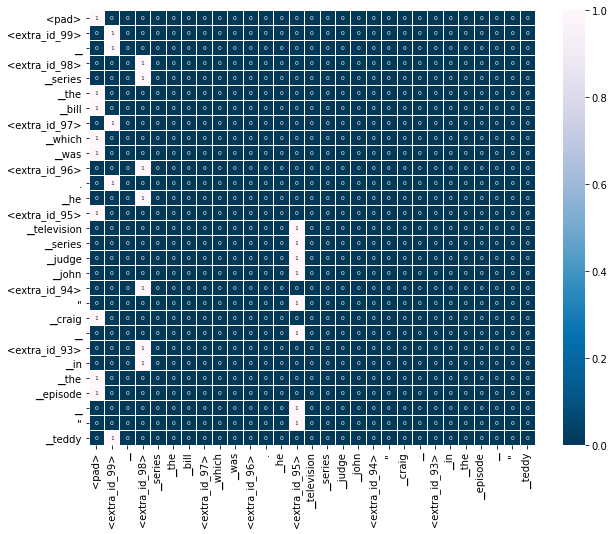

============================================================  batch 2 ===============================================================
decoder_attention[2] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


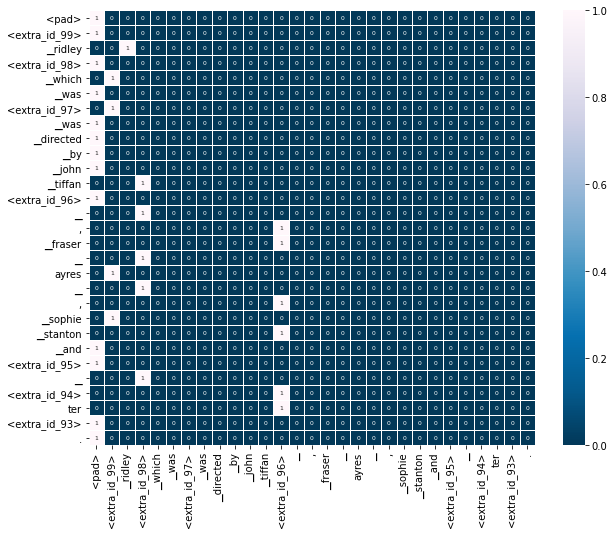

head:  2 torch.Size([29, 29])


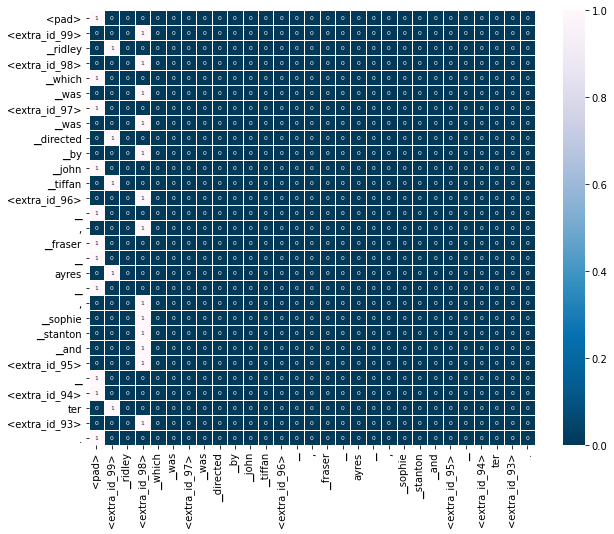

head:  3 torch.Size([29, 29])


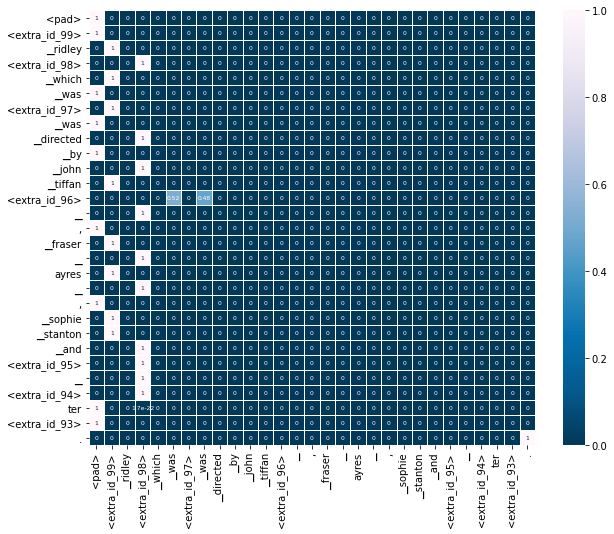

head:  4 torch.Size([29, 29])


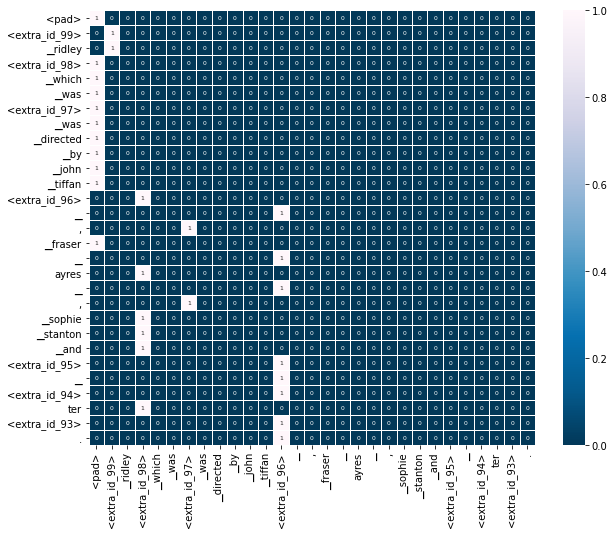

head:  5 torch.Size([29, 29])


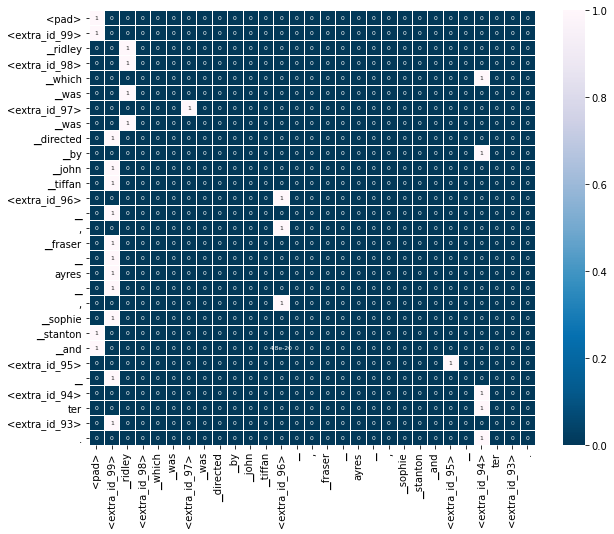

head:  6 torch.Size([29, 29])


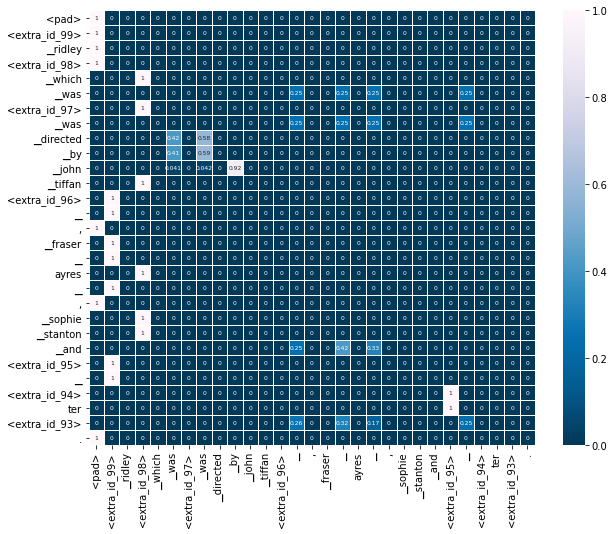

head:  7 torch.Size([29, 29])


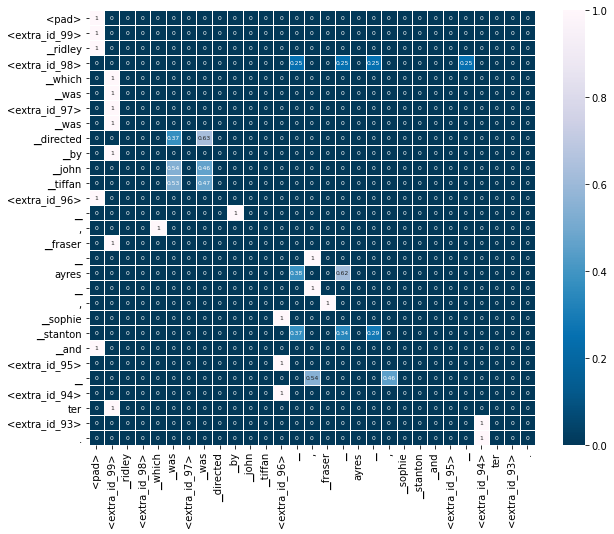

head:  8 torch.Size([29, 29])


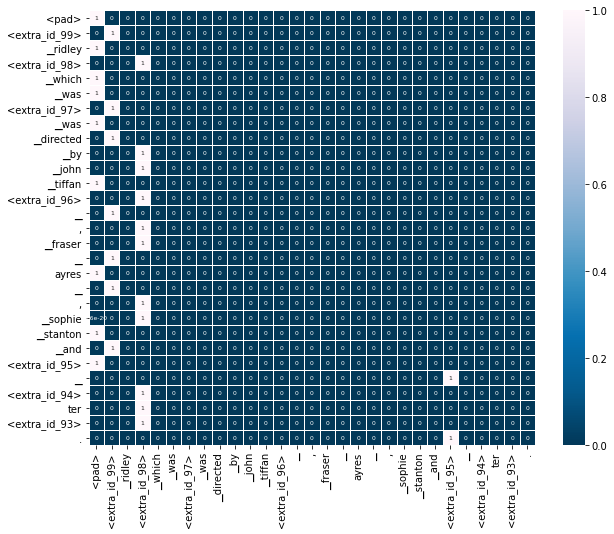

============================================================  batch 3 ===============================================================
decoder_attention[3] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


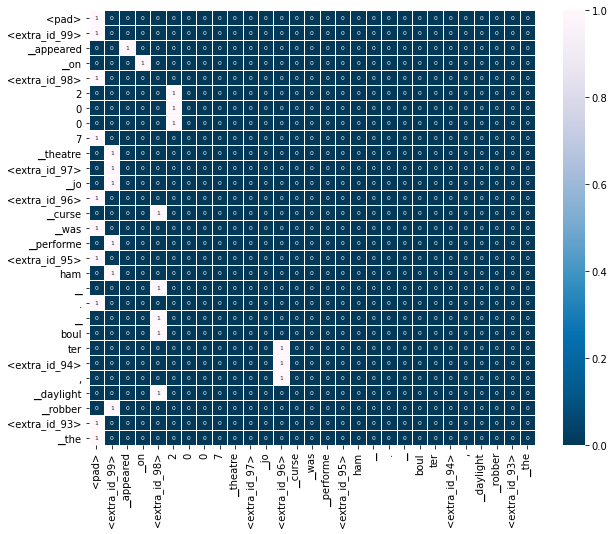

head:  2 torch.Size([29, 29])


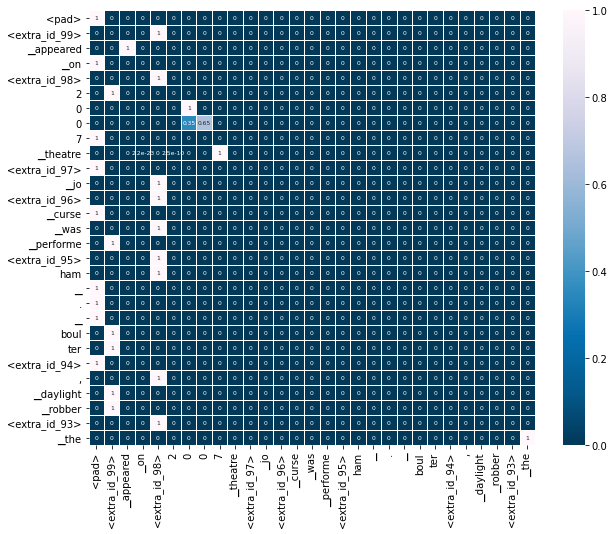

head:  3 torch.Size([29, 29])


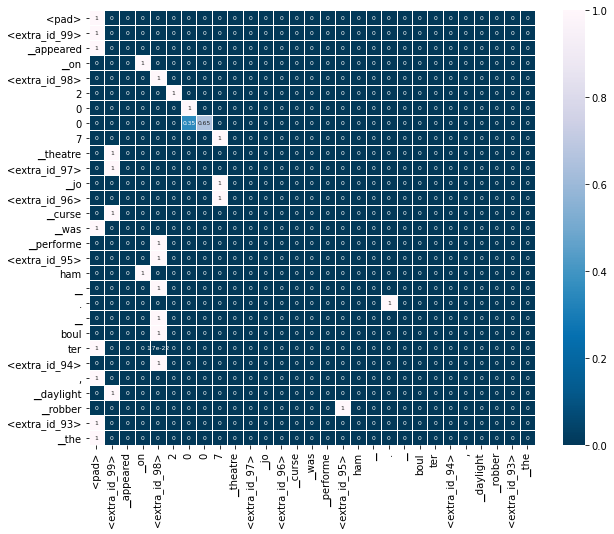

head:  4 torch.Size([29, 29])


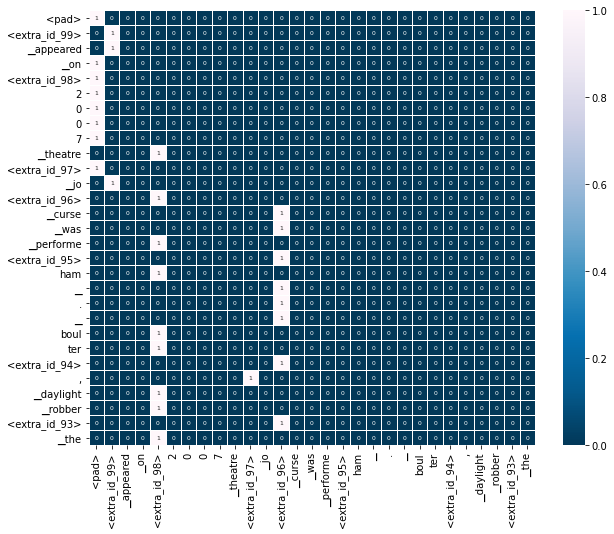

head:  5 torch.Size([29, 29])


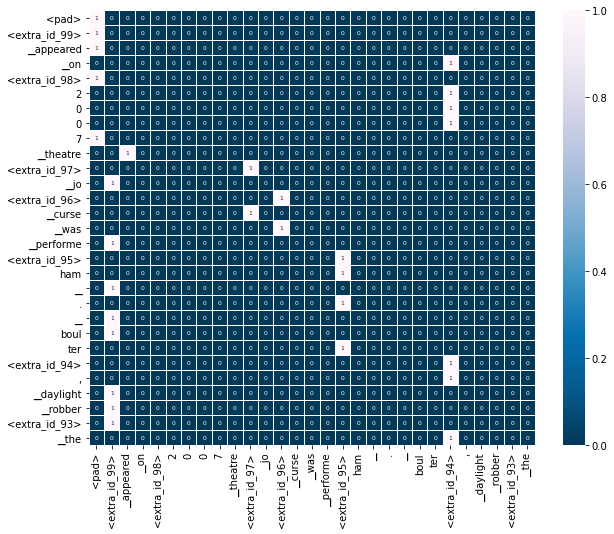

head:  6 torch.Size([29, 29])


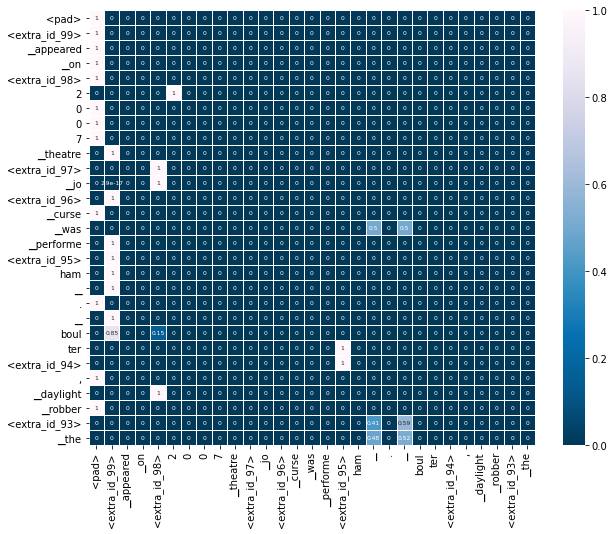

head:  7 torch.Size([29, 29])


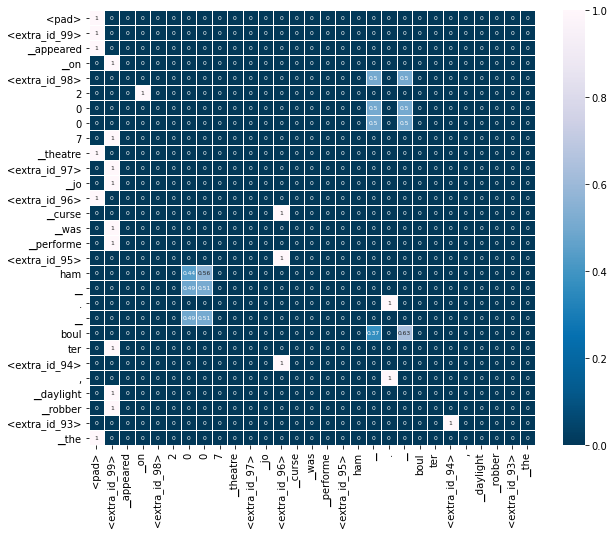

head:  8 torch.Size([29, 29])


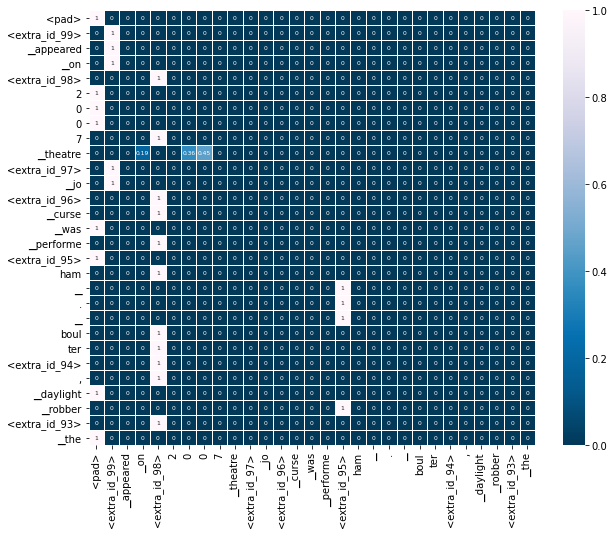

**********************************************************************************************************************************************
Decoder Layer 2
layer.shape;  torch.Size([3, 8, 29, 29])
============================================================  batch 1 ===============================================================
decoder_attention[1] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


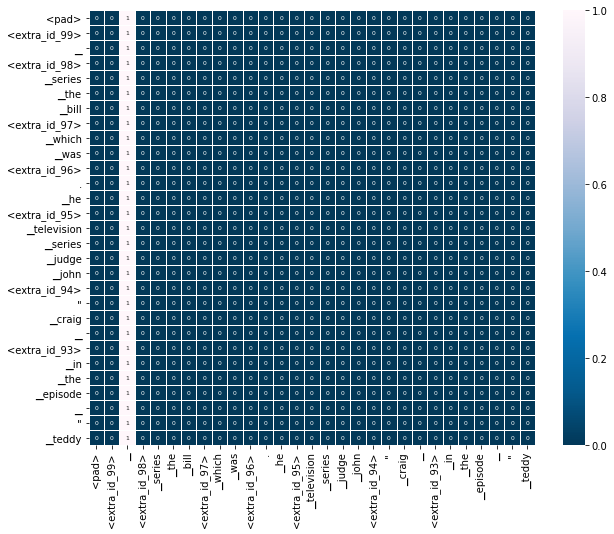

head:  2 torch.Size([29, 29])


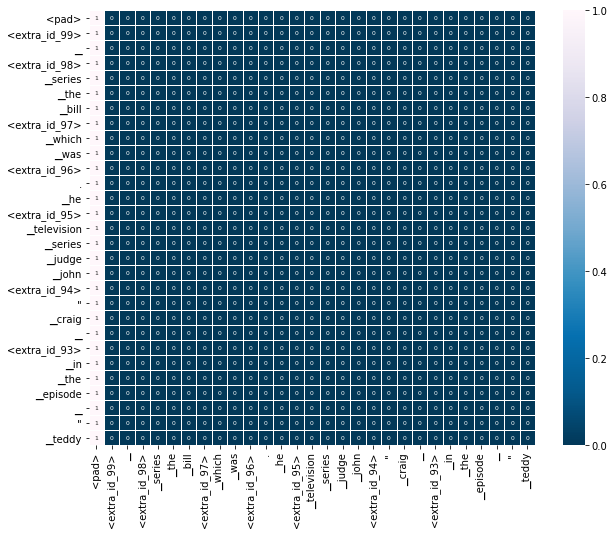

head:  3 torch.Size([29, 29])


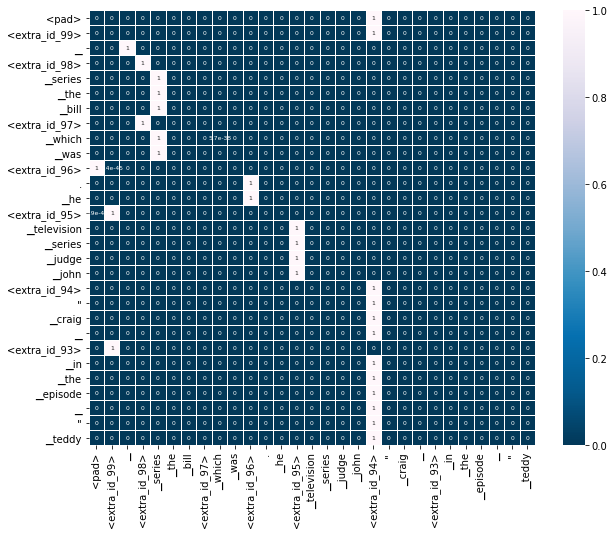

head:  4 torch.Size([29, 29])


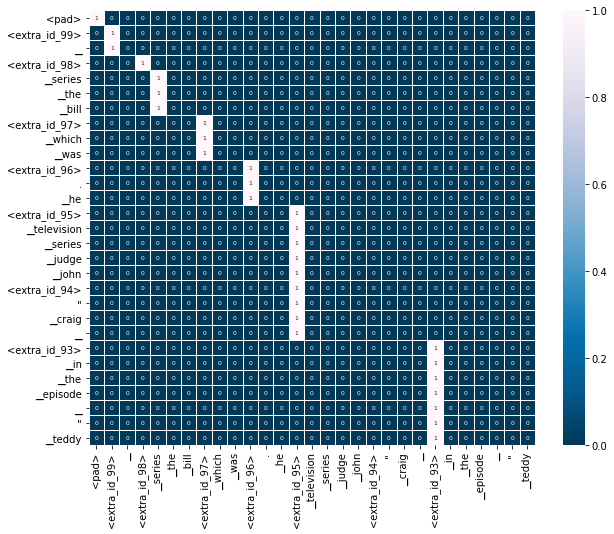

head:  5 torch.Size([29, 29])


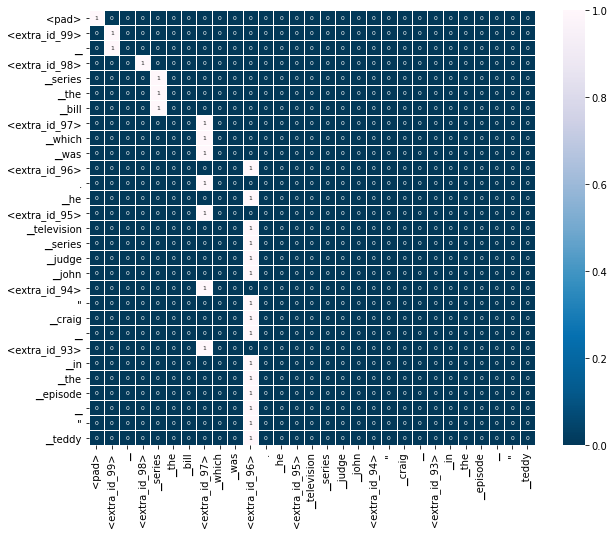

head:  6 torch.Size([29, 29])


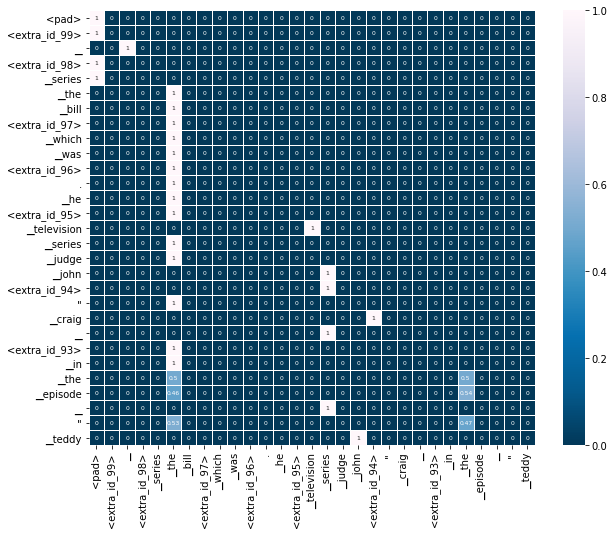

head:  7 torch.Size([29, 29])


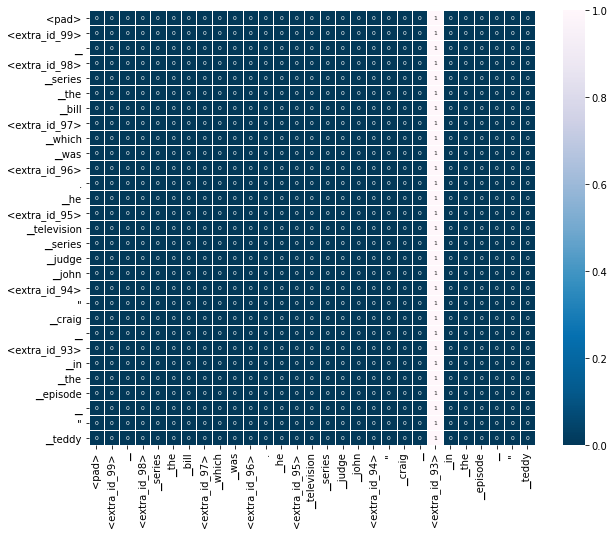

head:  8 torch.Size([29, 29])


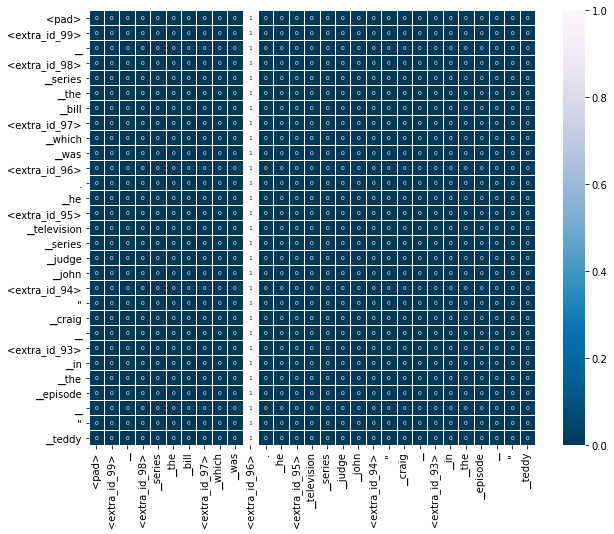

============================================================  batch 2 ===============================================================
decoder_attention[2] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


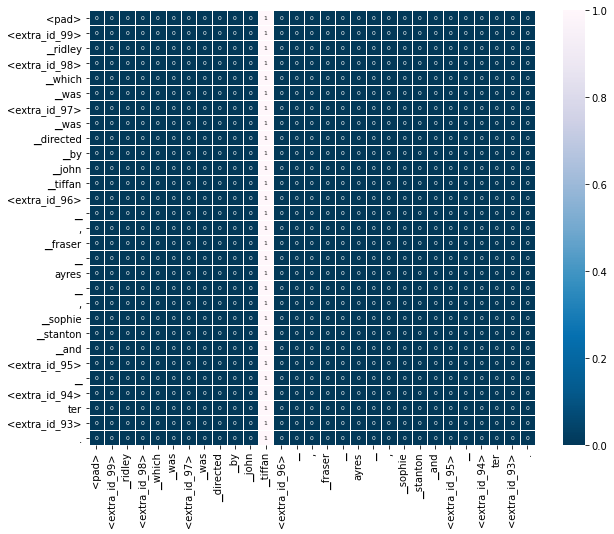

head:  2 torch.Size([29, 29])


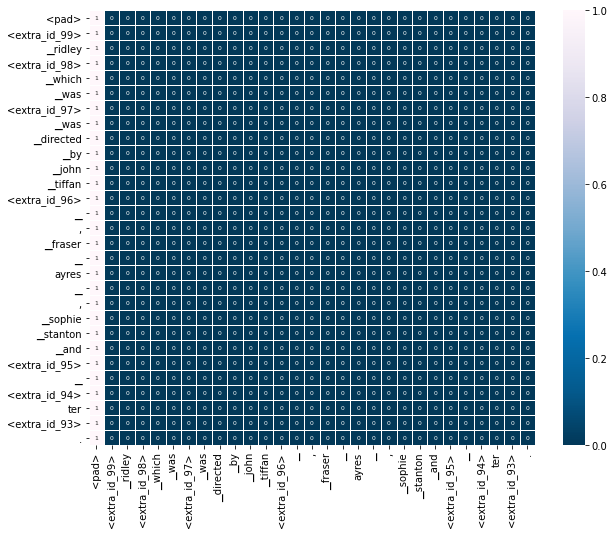

head:  3 torch.Size([29, 29])


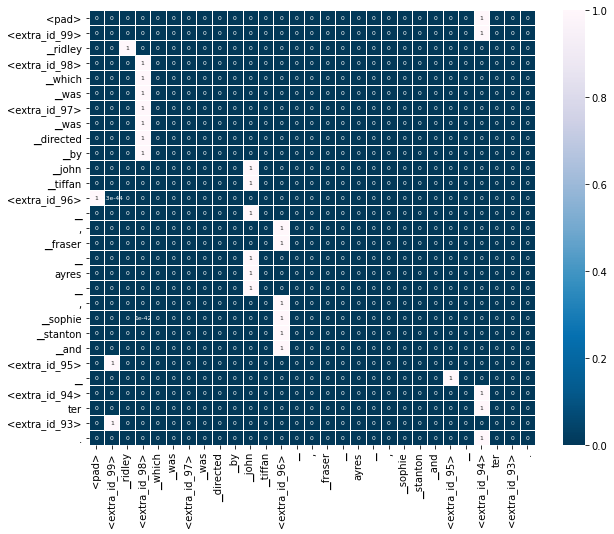

head:  4 torch.Size([29, 29])


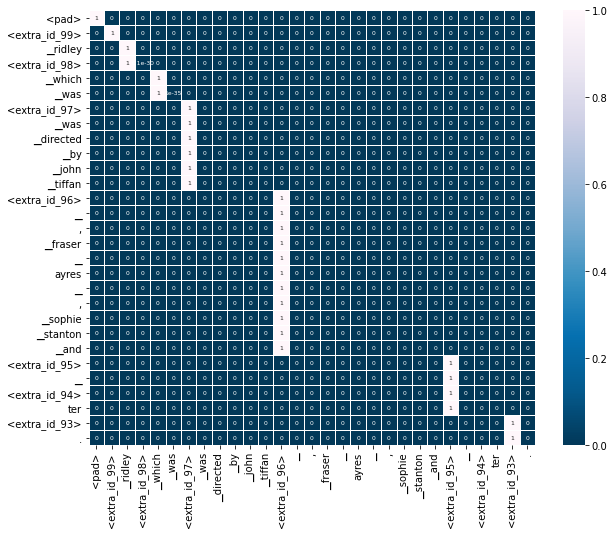

head:  5 torch.Size([29, 29])


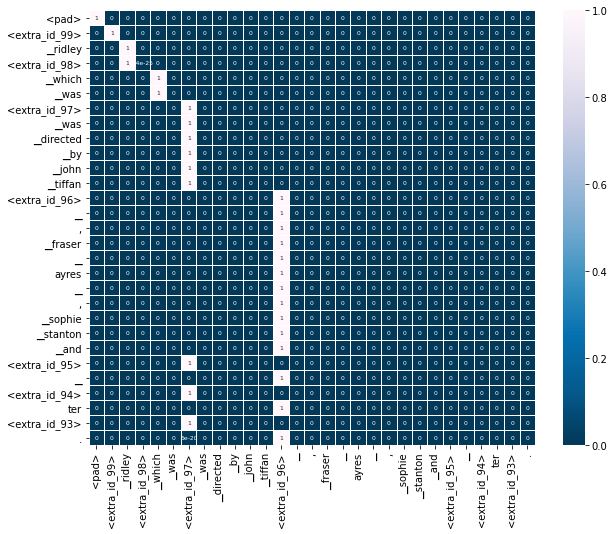

head:  6 torch.Size([29, 29])


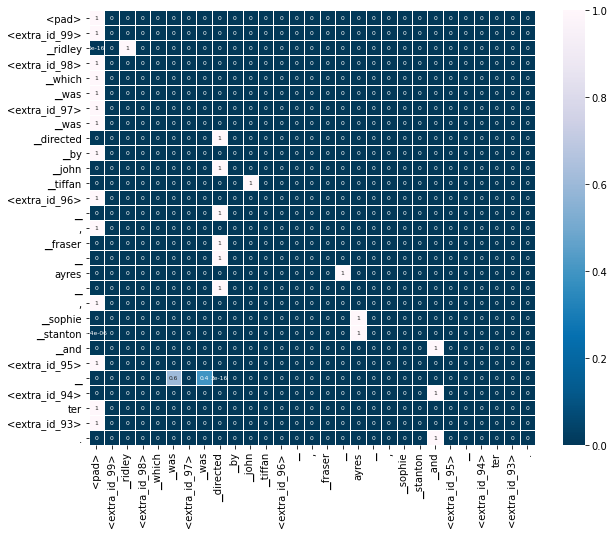

head:  7 torch.Size([29, 29])


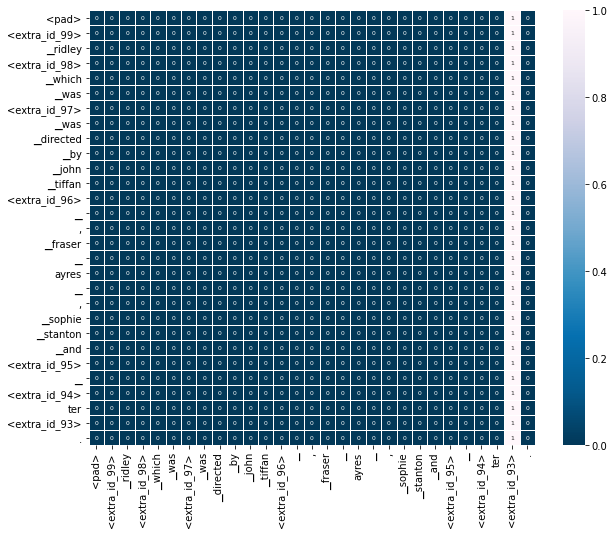

head:  8 torch.Size([29, 29])


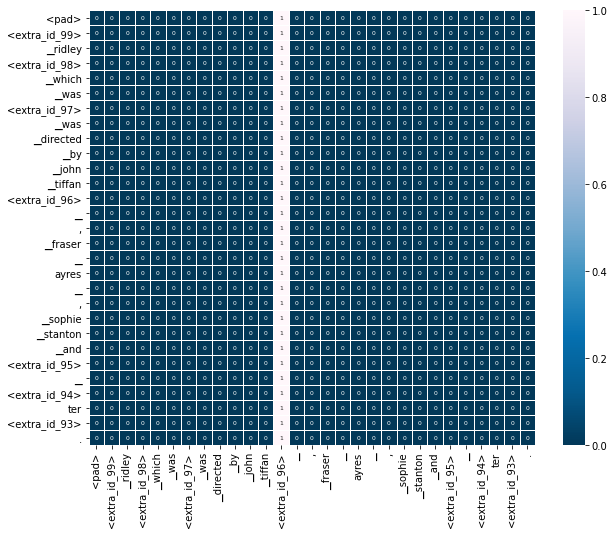

============================================================  batch 3 ===============================================================
decoder_attention[3] torch.Size([8, 29, 29])
attention:  torch.Size([8, 29, 29]) 8
head:  1 torch.Size([29, 29])


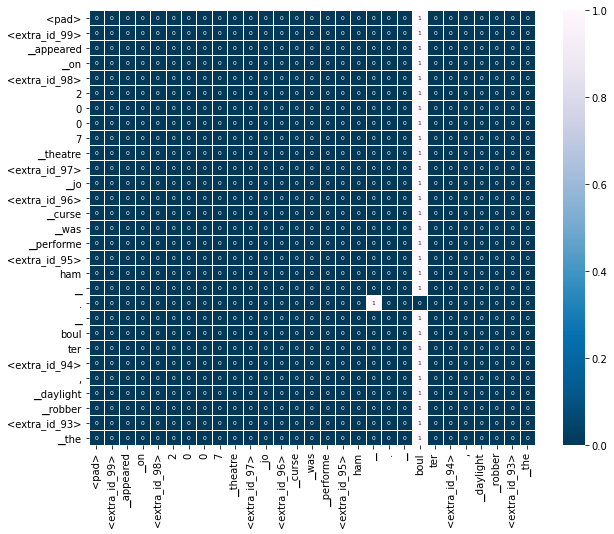

head:  2 torch.Size([29, 29])


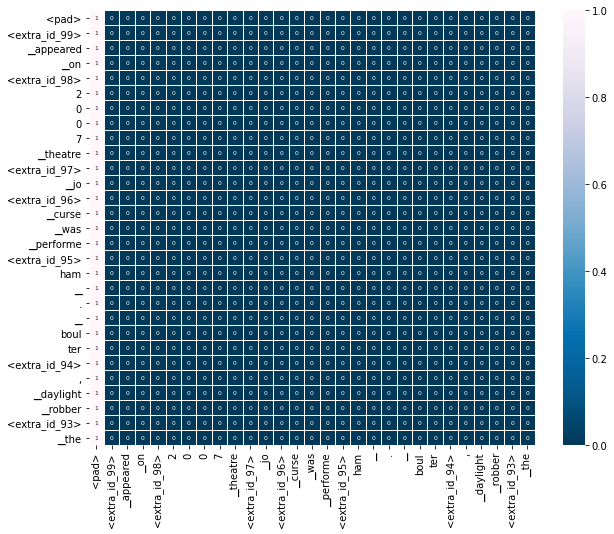

head:  3 torch.Size([29, 29])


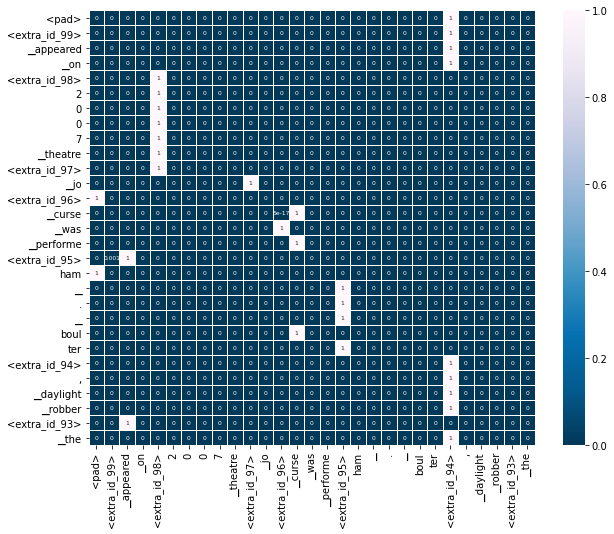

head:  4 torch.Size([29, 29])


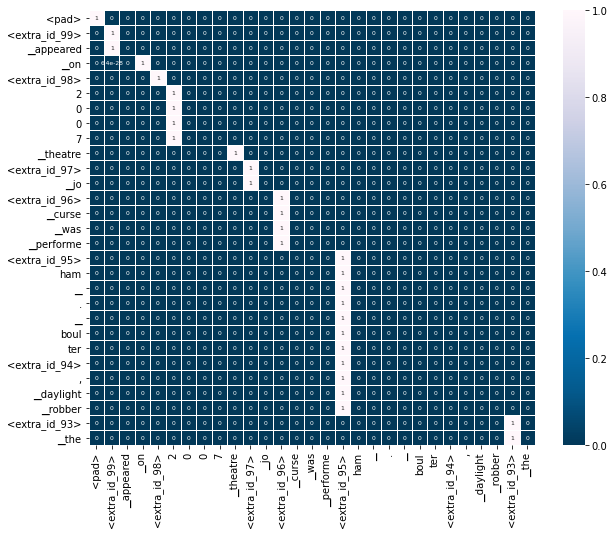

head:  5 torch.Size([29, 29])


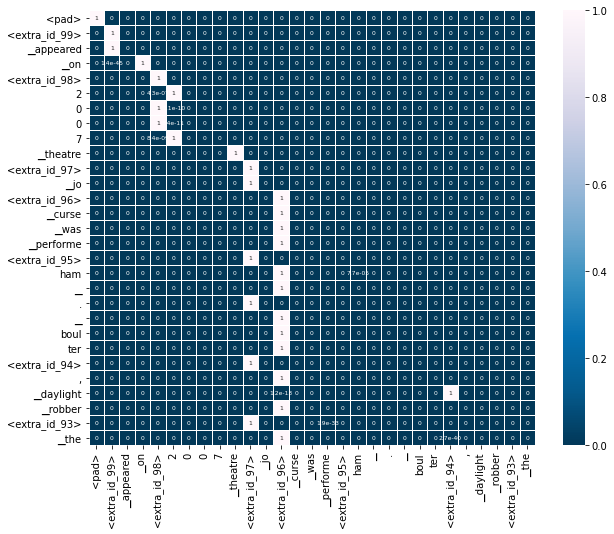

head:  6 torch.Size([29, 29])


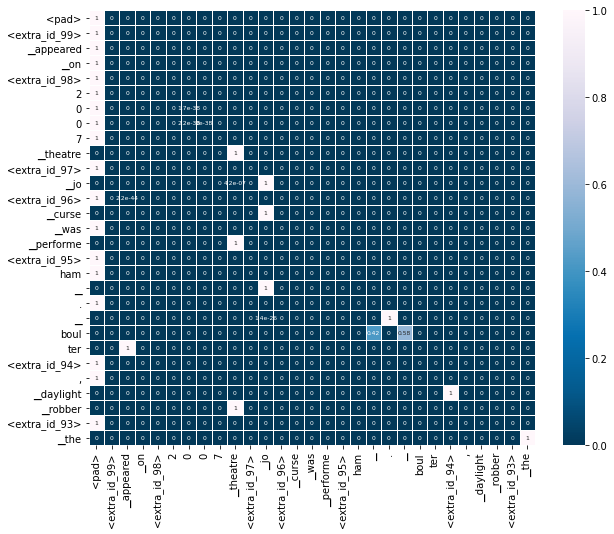

head:  7 torch.Size([29, 29])


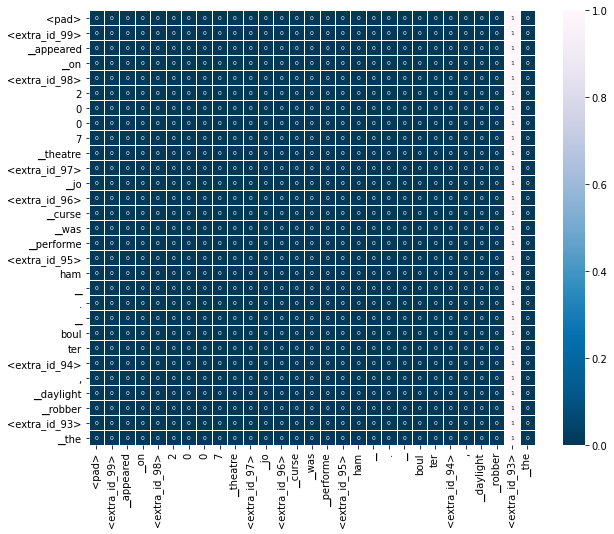

head:  8 torch.Size([29, 29])


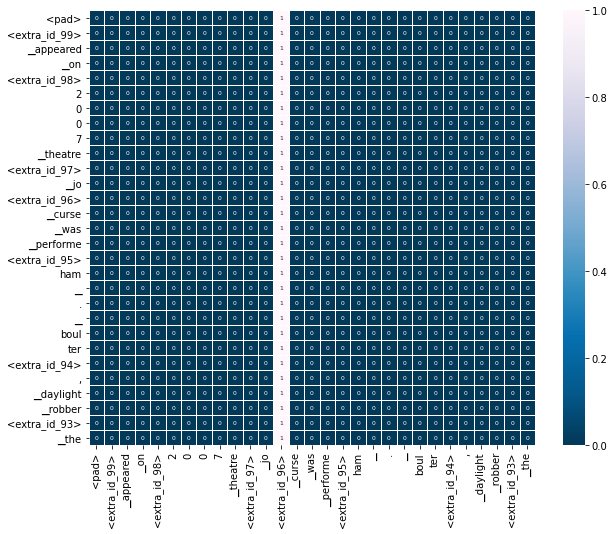

In [6]:
# '''
# https://github.com/samuel-stack/Seaborn-Cmap-Options/blob/master/Seaborn-Cmap-Options.ipynb
# cmaps = 'Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r'
# '''
import matplotlib.pyplot as plt
import seaborn

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, 
                    yticklabels=y, 
                    cmap="PuBu_r", 
                    linewidths=.9,
                    annot_kws={"fontsize":6},
                    annot=True,
                    ax=ax)
print("*****************************************************************************************************************************************************")
print("********************************************************  Decoder self attention         *****************************************************************")
print("*****************************************************************************************************************************************************")

print("Decoder_attentions shape", decoder_attentions[0].shape)
for num_layer, layer in enumerate(decoder_attentions):
    print("**********************************************************************************************************************************************")
    print("Decoder Layer", num_layer+1)
    print("layer.shape; ", layer.shape)    
    for i, attention in enumerate(layer):  # iterate over batches
        print(f"============================================================  batch {i+1} ===============================================================")
        print(f"decoder_attention[{i+1}]", attention.shape)
        sent_att =  attention
        print("attention: ", sent_att.shape, sent_att.shape[0])
        for num_head ,head in enumerate(sent_att):  # iterate over heads
            fig, axs = plt.subplots(1,1, figsize=(10,8))
            print("head: ", num_head+1, head.shape)
            draw(head.cpu(), 
                ground_selector_tokens[i], 
                ground_selector_tokens[i], 
                 ax=axs)
            plt.show()    
    print("==============================================================================================================================================")
    

In [ ]:
# if you want to see the 9 epoch

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
from src.T5_weights import Tester
from src.utils import load_config, create_logger
import argparse
import matplotlib.pyplot as plt

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--experiment_path', type=str, default='test_t5', help='path where to save model')
    parser.add_argument('--data_path', type=str, default=None, help='path with the sharded data in text format')
    parser.add_argument('--train_file_path', type=str, default='Data/wiki_103/128train_data.pt ',
                        help='path of processed train data')
    parser.add_argument('--valid_file_path', type=str, default='Data/wiki_103/128valid_data.pt ',
                        help='path of processed test data')

    parser.add_argument('--test_file_path', type=str, default='Data/wiki_103/128test_data.pt',
                        help='path of processed test data')
    
    
    parser.add_argument('--train_file', type=str, default=None,
                        help='The input training data file (a text file) to be processed.')
    parser.add_argument('--valid_file', type=str, default=None,
                        help='input evaluation data file to evaluate the perplexity on (a text file).')
    ##################################################
    parser.add_argument('--dataset_name', type=str, default='wikitext',
                        help='The name of the dataset to use (via the datasets library).')
    parser.add_argument('--dataset_config_name', type=str, default='wikitext-103-raw-v1',
                        help='The configuration name of the dataset to use (via the datasets library).')
    parser.add_argument('--max_seq_length', type=int, default=128,
                        help='The maximum total input sequence length after tokenization and masking. Sequences longer than this will be truncated. Default to the max input length of the model.')
    parser.add_argument('--processing_num_workers', type=int, default=1,
                        help='The number of processes to use for the preprocessing.')
    parser.add_argument('--overwrite_cache', type=bool, default=None,
                        help='Overwrite the cached training and evaluation sets')
    parser.add_argument('--mean_noise_span_length', type=float, default = 3.0, help='Mean span length of masked tokens.')
    parser.add_argument('--cache_dir', type=str, default = None, help='Where do you want to store the pretrained models downloaded from s3.')

    ##################################################
    parser.add_argument('--save_interval', type=int, default=10, help='save model every steps')
    parser.add_argument('--working_dir', type=str, default='.',
                        help='working dir, should be a dir with t5-experiments repo (default: .)')

    # model args
    parser.add_argument('--model_size', type=str, default='t5-small',
                        help='model_size specifies the base model name (from huggingface) (default: t5-small)')
    parser.add_argument('--tokenizer_path', type=str, default='tokenizer/',
                        help='tokenizer_path specifies the base tokenizer name (from huggingface) (default: t5-small)')

    parser.add_argument('--config_dir', type=str,default='./configs',
                        help='path to model configuration file (default: None)')  #  T5Mem_config.json,  t5-small
    parser.add_argument('--model_name', type=str, default='transformers:T5ForConditionalGeneration',  #Models.T5MemModel:T5MemForConditionalGeneration or transformers:T5ForConditionalGeneration
                        help='model class name to use (default: transformers:T5ForConditionalGeneration)')
    
    
    
############################ to finetune here put the checkpoint
    parser.add_argument('--init_checkpoint', type=str, default = 'MLM/128/9_model.pt',
                        help='path to init checkpoint to load a model from (default: None).')


    # training args
    parser.add_argument('--task', type=str, default="mlm", help='task type')
    parser.add_argument('--lr', type=float, default=0.005, help='learning rate (default: None)')
    parser.add_argument('--batch_size', type=int, default=3, help='input batch size for training (default: 20)')
    parser.add_argument('--max_train_steps', type=int, default=None, help='max_train_steps')
    
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training steps (i.e., gradient updates) (default: 100).')
    parser.add_argument('--patience', type=int, default=10,
                        help='number of epochs with no improvement after which learning rate will be reduced (default: 3).')
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help='number of batches to accumulate gradients for each worker; it multiplies total batch size.')
    parser.add_argument('--reduction_factor', type=float, default=0.1, help='learning rate (default: 0.1)')
    parser.add_argument('--min_lr', type=float, default=0.00000001, help='learning rate (default: 0.1)')
    parser.add_argument('--fp16-allreduce', action='store_true', default=False,
                        help='use fp16 compression during allreduce')
    parser.add_argument('--fp16', action='store_true', default=False, help='use torch.amp for fp16 training')
    parser.add_argument('--apex_opt_lvl', type=str, default='O1', help='apex opt level, O1, O2. (default: O1)')
    parser.add_argument('--optimizer', type=str, default='Adafactor',
                        help='optimizer name: AdamW, Adafactor. (default: AdamW)')
    parser.add_argument('--weight_decay', type=float, default=0.001,
                        help='optimizer weight decay (default: 0.0)')
    parser.add_argument('--scale_parameter', action='store_true', default=False,
                        help='Adafactor scale_parameter (default: False)')
    parser.add_argument('--relative_step', action='store_true', default=False,
                        help='Adafactor relative_step (default: False)')
    parser.add_argument('--warmup_init', action='store_true', default=True,
                        help='Adafactor warmup_init (default: False)')
    parser.add_argument('--warmup_steps', action='store_true', default=2000,
                        help='number of warm up steps')
    parser.add_argument('--mlm_probability', type=float, default=0.15, help= "Ratio of tokens to mask for span masked language modeling loss")
    

    parser.add_argument('--evaluate_dev', action='store_true', default=True,
                        help='Evaluating during training process(default: True)')
    
    args, unknown = parser.parse_known_args() 
    args = parser.parse_args(args=[])
    return args

def main()-> tuple:

    # load args
    args = parse_args()
    args.config_path = args.config_dir + '/t5-small.json'
    # load config
    config = load_config(args)
    tester = Tester(config, args)
    return tester.return_weights()

In [ ]:
# '''
# https://github.com/samuel-stack/Seaborn-Cmap-Options/blob/master/Seaborn-Cmap-Options.ipynb
# cmaps = 'Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r'
# '''
import matplotlib.pyplot as plt
import seaborn

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, 
                    yticklabels=y, 
                    cmap="PuBu_r", 
                    linewidths=.9,
                    annot_kws={"fontsize":6},
                    annot=True,
                    ax=ax)
print("*****************************************************************************************************************************************************")
print("********************************************************  Decoder self attention         *****************************************************************")
print("*****************************************************************************************************************************************************")

print("Decoder_attentions shape", decoder_attentions[0].shape)
for num_layer, layer in enumerate(decoder_attentions):
    print("**********************************************************************************************************************************************")
    print("Decoder Layer", num_layer+1)
    print("layer.shape; ", layer.shape)    
    for i, attention in enumerate(layer):  # iterate over batches
        print(f"============================================================  batch {i+1} ===============================================================")
        print(f"decoder_attention[{i+1}]", attention.shape)
        sent_att =  attention
        print("attention: ", sent_att.shape, sent_att.shape[0])
        for num_head ,head in enumerate(sent_att):  # iterate over heads
            fig, axs = plt.subplots(1,1, figsize=(10, 10))
            print("head: ", num_head+1, head.shape)
            draw(head.cpu(), 
                ground_selector_tokens[i], 
                ground_selector_tokens[i], 
                 ax=axs)
            
            plt.show()    
    print("==============================================================================================================================================")
    